# Global SST - RYF

In [1]:
RUNS = {
    "b_grid": '/g/data/tm70/as2285/MOM6-CICE6-b_grid',  # (our name: run name(s))
    "c_grid": '/g/data/tm70/as2285/MOM6-CICE6-c_grid',
}

In [2]:
VARS = ["tos", "sos" ]  #sea surface temperature, and sea surface salinity

In [ ]:
from intake import open_esm_datastore
import xarray as xr
import cf_xarray
import matplotlib.pyplot as plt
from datatree import DataTree, map_over_subtree

from dask.distributed import Client

In [9]:
client = Client(threads_per_worker=1)

client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43239 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43239/status,
Dashboard: /proxy/43239/status,Workers: 12
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41067,Workers: 12
Dashboard: /proxy/43239/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:41033,Total threads: 1
Dashboard: /proxy/36007/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:39727,


In [10]:
def open_by_path(path, vars):
    """Return a dataset for the requested name and vars"""
    return (
        open_esm_datastore(
            path + '/intake_datastore.json',
            columns_with_iterables=["variable"] 
        )
        .search(variable=vars,frequency="1mon")
        .to_dask(
            xarray_combine_by_coords_kwargs={
                "compat": "override",
                "data_vars": "minimal",
                "coords": "minimal",
            },
        )
    )

Make a datatree containing the requested vars and the requested experiments

In [11]:
name_ds_pairs = [(iRun, open_by_path(RUNS[iRun], VARS)) for iRun in RUNS.keys()]

In [12]:
sfc_dt = DataTree.from_dict(dict(name_ds_pairs))

In [13]:
sfc_dt['b_grid']

DataTree('b_grid', parent="None")
    Dimensions:  (time: 480, yh: 300, xh: 360)
    Coordinates:
      * time     (time) object 4kB 1900-01-16 12:00:00 ... 1939-12-16 12:00:00
      * yh       (yh) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
      * xh       (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
    Data variables:
        sos      (time, yh, xh) float32 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
        tos      (time, yh, xh) float32 207MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    Attributes: (12/16)
        NumFilesInSet:                            1
        title:                                    MOM6 diagnostic fields table
        associated_files:                         areacello: access-om3.mom6.h.st...
        grid_type:                                regular
        grid_tile:                                N/A
        intake_esm_vars:                          ['sos', 'tos']
        ...                                       ...
        intake_esm_attrs:variable_standard_name:  ['sea_water_salinity', 'sea_wat...
        intake_esm_attrs:variable_cell_methods:   ['time: mean', 'time: mean', 'z...
        intake_esm_attrs:variable_units:          ['psu', 'degC', 'm3 s-1', 'm3 s...
        intake_esm_attrs:file_id:                 access_om3_mom6_h_native_XXXX_XX
        intake_esm_attrs:_data_format_:           netcdf
        intake_esm_dataset_key:                   access_om3_mom6_h_native_XXXX_X...

In [14]:
sfc_dt['b_grid'].ds.cf

Coordinates:
             CF Axes: * X: ['xh']
                      * Y: ['yh']
                      * T: ['time']
                        Z: n/a

      CF Coordinates: * longitude: ['xh']
                      * latitude: ['yh']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area, volume: n/a

      Standard Names:   sea_surface_salinity: ['sos']
                        sea_surface_temperature: ['tos']

              Bounds:   n/a

       Grid Mappings:   n/a

In [15]:
@map_over_subtree
def global_mean(ds):
    return ds.cf.mean(['X','Y'])

In [16]:
sfc_glob_dt = global_mean(sfc_dt)

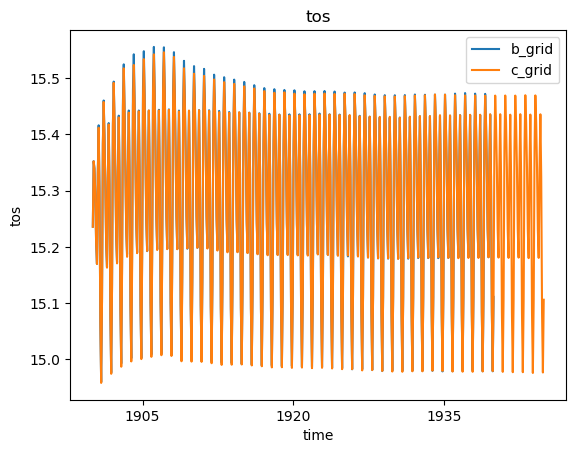

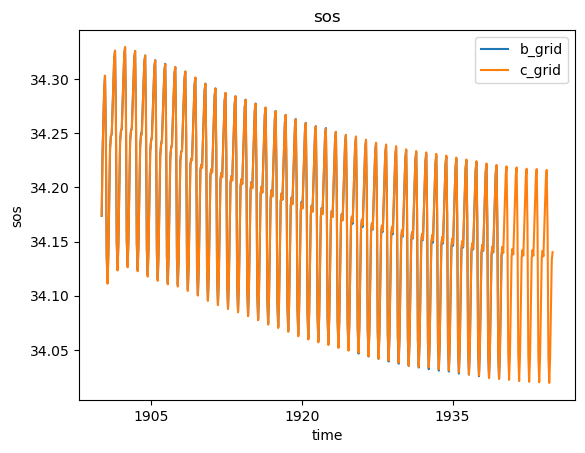

In [17]:
for iVar in VARS:
    plt.figure()
    
    for iGroup in sfc_glob_dt.groups[1:]:
        sfc_glob_dt[iGroup].ds[iVar].plot(label=iGroup[1:])

    plt.title(iVar)
    _ = plt.legend()
    

In [18]:
@map_over_subtree
def year_min(ds):
    return ds.groupby('time.year').min()

@map_over_subtree
def year_max(ds):
    return ds.groupby('time.year').max()

In [19]:
min_sfc_global_dt = year_min(sfc_glob_dt)
max_sfc_global_dt = year_max(sfc_glob_dt)

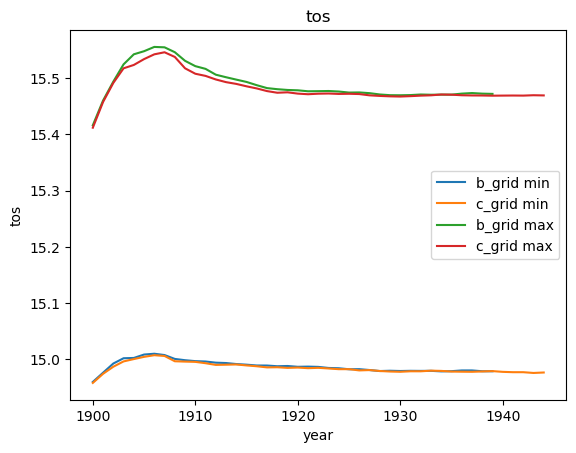

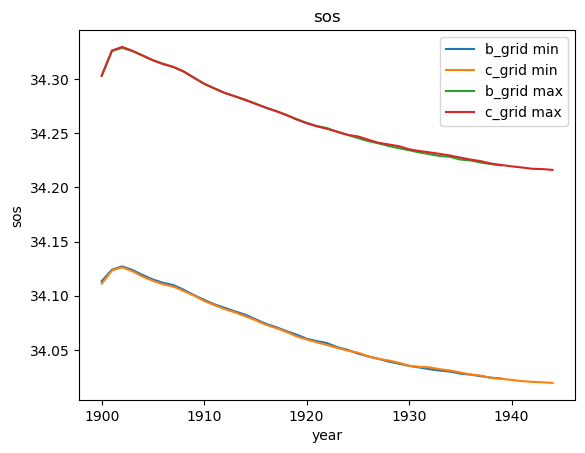

In [21]:
for iVar in VARS:
    plt.figure()

    for iGroup in min_sfc_global_dt.groups[1:]:
        min_sfc_global_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' min')
    
    for iGroup in max_sfc_global_dt.groups[1:]:
        max_sfc_global_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' max')

    plt.title(iVar)
    _ = plt.legend()
    

In [22]:
VARS_GLOB = ['thetaoga', 'soga']

In [23]:
name_ds_pairs = [(iRun, open_by_path(RUNS[iRun], VARS_GLOB)) for iRun in RUNS.keys()]

In [24]:
ocn_glob_dt = DataTree.from_dict(dict(name_ds_pairs))

In [25]:
min_global_dt = year_min(ocn_glob_dt)
max_global_dt = year_max(ocn_glob_dt)

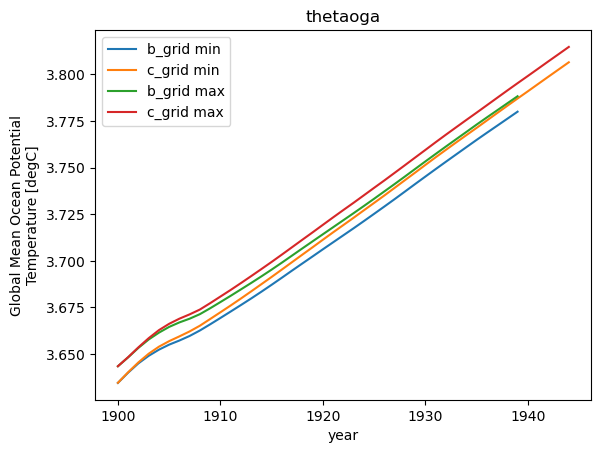

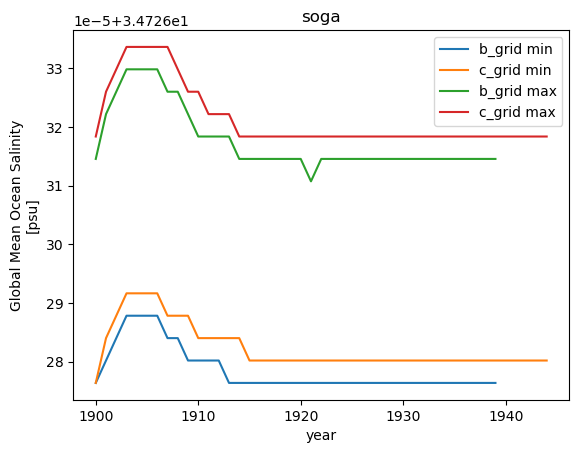

In [26]:
for iVar in VARS_GLOB:
    plt.figure()

    for iGroup in min_global_dt.groups[1:]:
        min_global_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' min')
    
    for iGroup in max_global_dt.groups[1:]:
        max_global_dt[iGroup].ds[iVar].plot(label=iGroup[1:]+' max')

    plt.title(iVar)
    _ = plt.legend()
    